### Подключение библиотек

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KDTree
import random
import matplotlib.pyplot as plt
import time
import pickle
from IPython.display import Image

### Считаем данные

Теоретические данные

In [3]:
X_test_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_th\X_test_array.npy")
X_train_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_th\X_train_array.npy")
y_test_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_th\y_test_array.npy")
y_train_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_th\y_train_array.npy")

Экспериментальные данные

In [4]:
X_exp_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_exp1\X_exp_array.npy")
X_th_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_exp1\X_th_array.npy")
y_th_array = np.load(r"C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\df\df_exp1\y_th_array.npy")

df_exp для получения колонок

In [7]:
df_ex = pd.read_csv(r'c:\Users\trrak\OneDrive\Рабочий стол\platelets\project_FC\experimental_1_degree.csv', sep=';')
df_ex = df_ex.drop('70', axis=1)

### Weighting function (doi: 10.1117/1.JBO.18.1.017001)

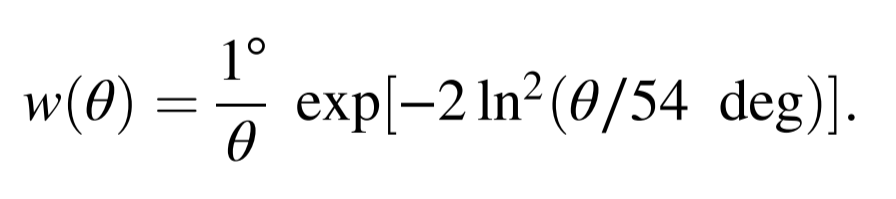

In [12]:
image_path = 'images\weight_formula.png'
Image(filename=image_path, width=600)

![](images\weight_formula.png)

In [8]:
def weight_formula(θ):
    return (1/θ)*np.exp(-2*(np.log(θ/54))**2)

θ = np.array(df_ex.columns, dtype='double')
weight = weight_formula(θ)

Для теоретических данных применяем веса

In [9]:
X_train_weighted = X_train_array * weight 
X_test_weighted = X_test_array * weight 

Для практических данных применяем веса

In [10]:
X_th_weighted = X_th_array * weight
X_exp_weighted = X_exp_array * weight 

### Применим KDTree на синтетических данных

In [18]:
tree = KDTree(X_train_weighted, leaf_size=10)  
time_one = time.time()
s = pickle.dumps(tree)   
tree_copy = pickle.loads(s)  
dist, ind = tree_copy.query(X_test_weighted, k=1)
time_two = time.time()

In [19]:
# Время выполнения одной строки
(time_two - time_one) / len(X_test_weighted)

0.0001335620892282174

In [25]:
index_results = []
for i in range(len(ind)):
    index_results.append(ind[i][0])


In [28]:
np.savetxt(r'C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\alg_search_files\index_th.txt', index_results)

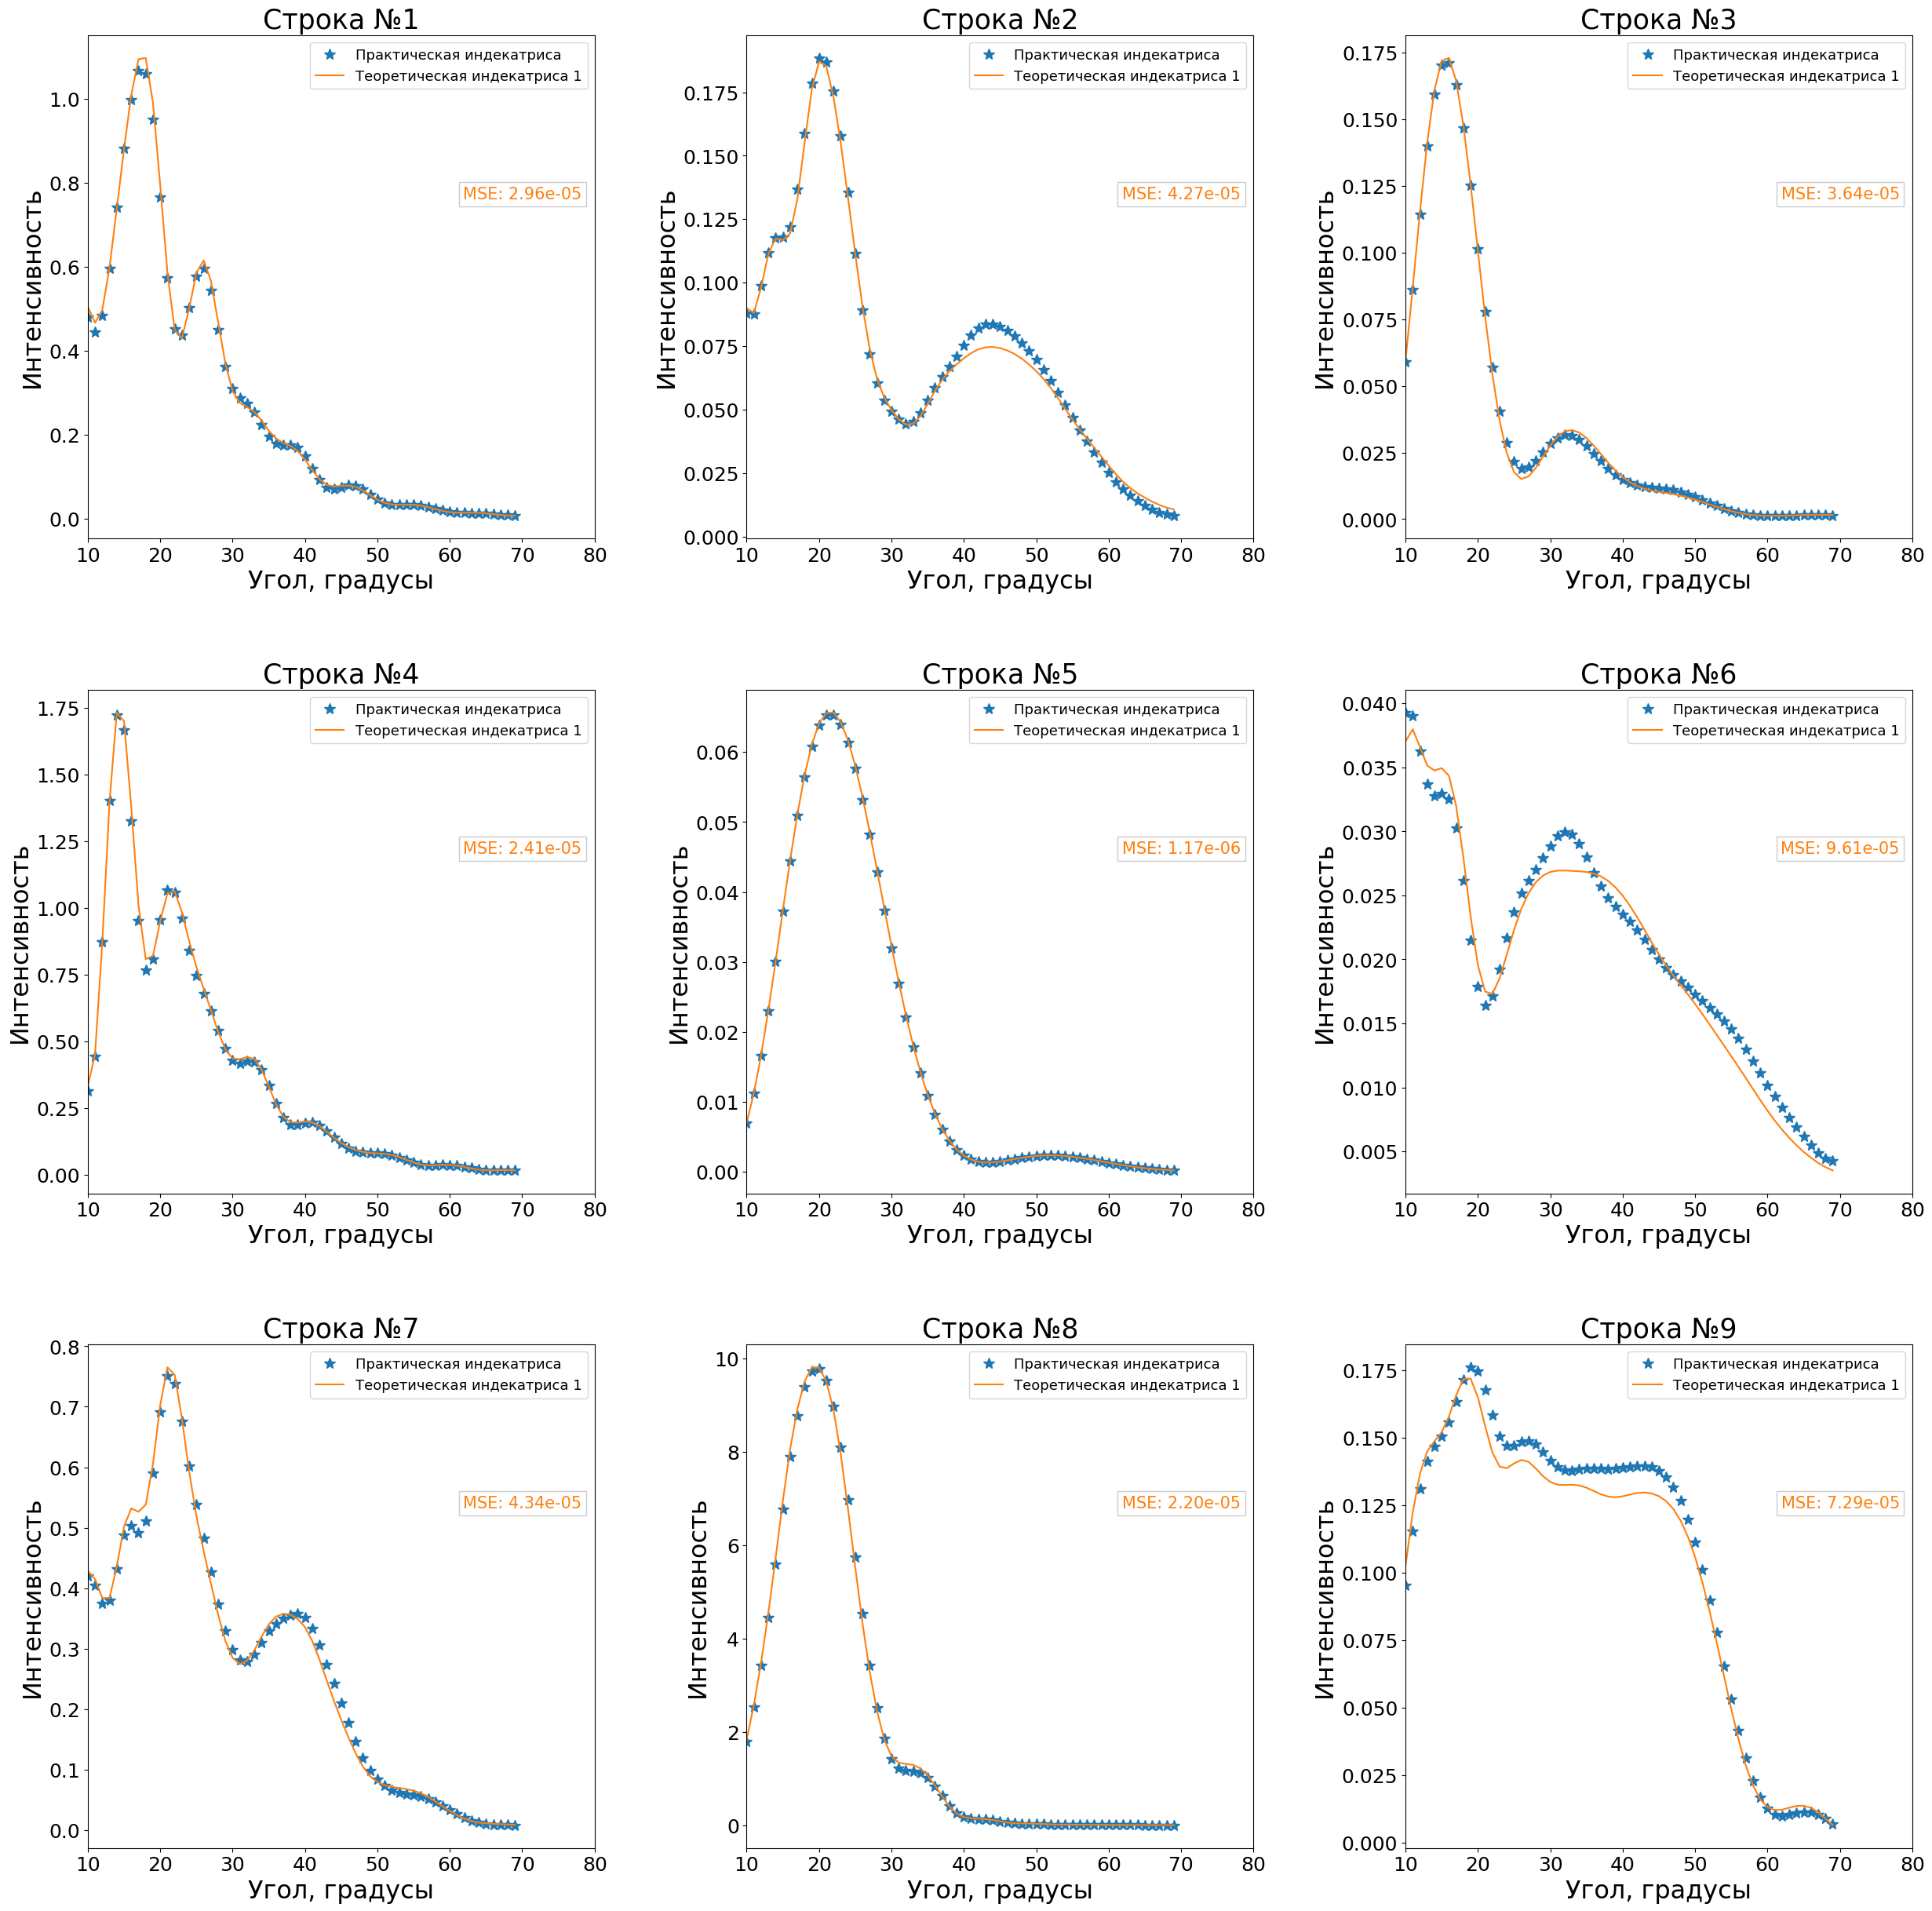

In [29]:
import matplotlib.pyplot as plt

# Общее количество графиков
num_plots = 9  
# Количество строк
rows = 3  
# Количество столбцов
cols = 3  

fig, axes = plt.subplots(rows, cols, figsize=(30, 30))

# Итерация по всем графикам
for i in range(num_plots):

    # Определение текущих строк и столбцов
    row = i // cols
    col = i % cols
    
    # Первые 5 индексов из ind для Train
    row_indices_train = ind[i][:5]  

    # Получение значений интенсивности от угла для выбранных строк
    intensities_test = X_test_weighted[i]
    intensities_train = X_train_weighted[row_indices_train]

    # Получение углы от 10 до 69 градусов для оси X
    angles = range(10, 70)

    # Список меток для легенды
    labels_train = ['Теоретическая индекатриса {}'.format(i+1) for i in range(len(row_indices_train))]

    # График практической индекатрисы на текущем подграфике
    axes[row, col].plot(angles, intensities_test, label='Практическая индекатриса', marker='*', markersize=10, linestyle='None') 

    # Рассчет mse для лучшего соответствия
    mse = (mean_squared_error(X_train_weighted[ind[i][0]], X_test_weighted[i], multioutput='raw_values')) / ((np.sum(X_train_weighted[ind[i][0]])**2) / len(X_train_weighted[ind[i][0]]))

    # Отображение MSE на графике
    axes[row, col].text(0.975, 0.7, 'MSE: {:.2e}'.format(mse[0]),
                    verticalalignment='top', horizontalalignment='right',
                    transform=axes[row, col].transAxes,
                    color='#ff7f0e', fontsize=15, bbox=dict(facecolor='white', alpha=0.2))


    # Графики теоретических индекатрис на текущем подграфике
    for j, intensities in enumerate(intensities_train):
        axes[row, col].plot(angles, intensities, label=labels_train[j]) 

    # Легенда на текущем подграфике
    axes[row, col].legend(fontsize=13, loc='upper right') 

    # Подписи осей и заголовок на текущем подграфике
    axes[row, col].set_xlabel('Угол, градусы', fontsize=23)  
    axes[row, col].set_ylabel('Интенсивность', fontsize=23) 
    axes[row, col].set_title('Строка №{}'.format(i+1), fontsize=25) 

    # Размер шрифта делений на осях
    axes[row, col].tick_params(axis='both', labelsize=18) 

    axes[row, col].set_xlim(10, 80)

# Увеличение расстояния между графиками
plt.subplots_adjust(hspace=0.3, wspace=0.3)  
plt.show()


### Применим KDTree на экспериментальных данных

In [32]:
tree = KDTree(X_th_weighted, leaf_size=10)  
time_one = time.time()
s = pickle.dumps(tree)   
tree_copy = pickle.loads(s)  
dist, ind = tree_copy.query(X_exp_weighted, k=1)
time_two = time.time()

In [35]:
X_exp_weighted.shape

(17441, 60)

In [33]:
# Время выполнения одной строки
(time_two - time_one) / len(X_exp_weighted)

0.0019903050110937634

In [36]:
index_results = []
for i in range(len(ind)):
    index_results.append(ind[i][0])

In [39]:
np.savetxt(r'C:\Users\trrak\OneDrive\Рабочий стол\InvBloodSolver\alg_search_files\index_exp.txt', index_results)

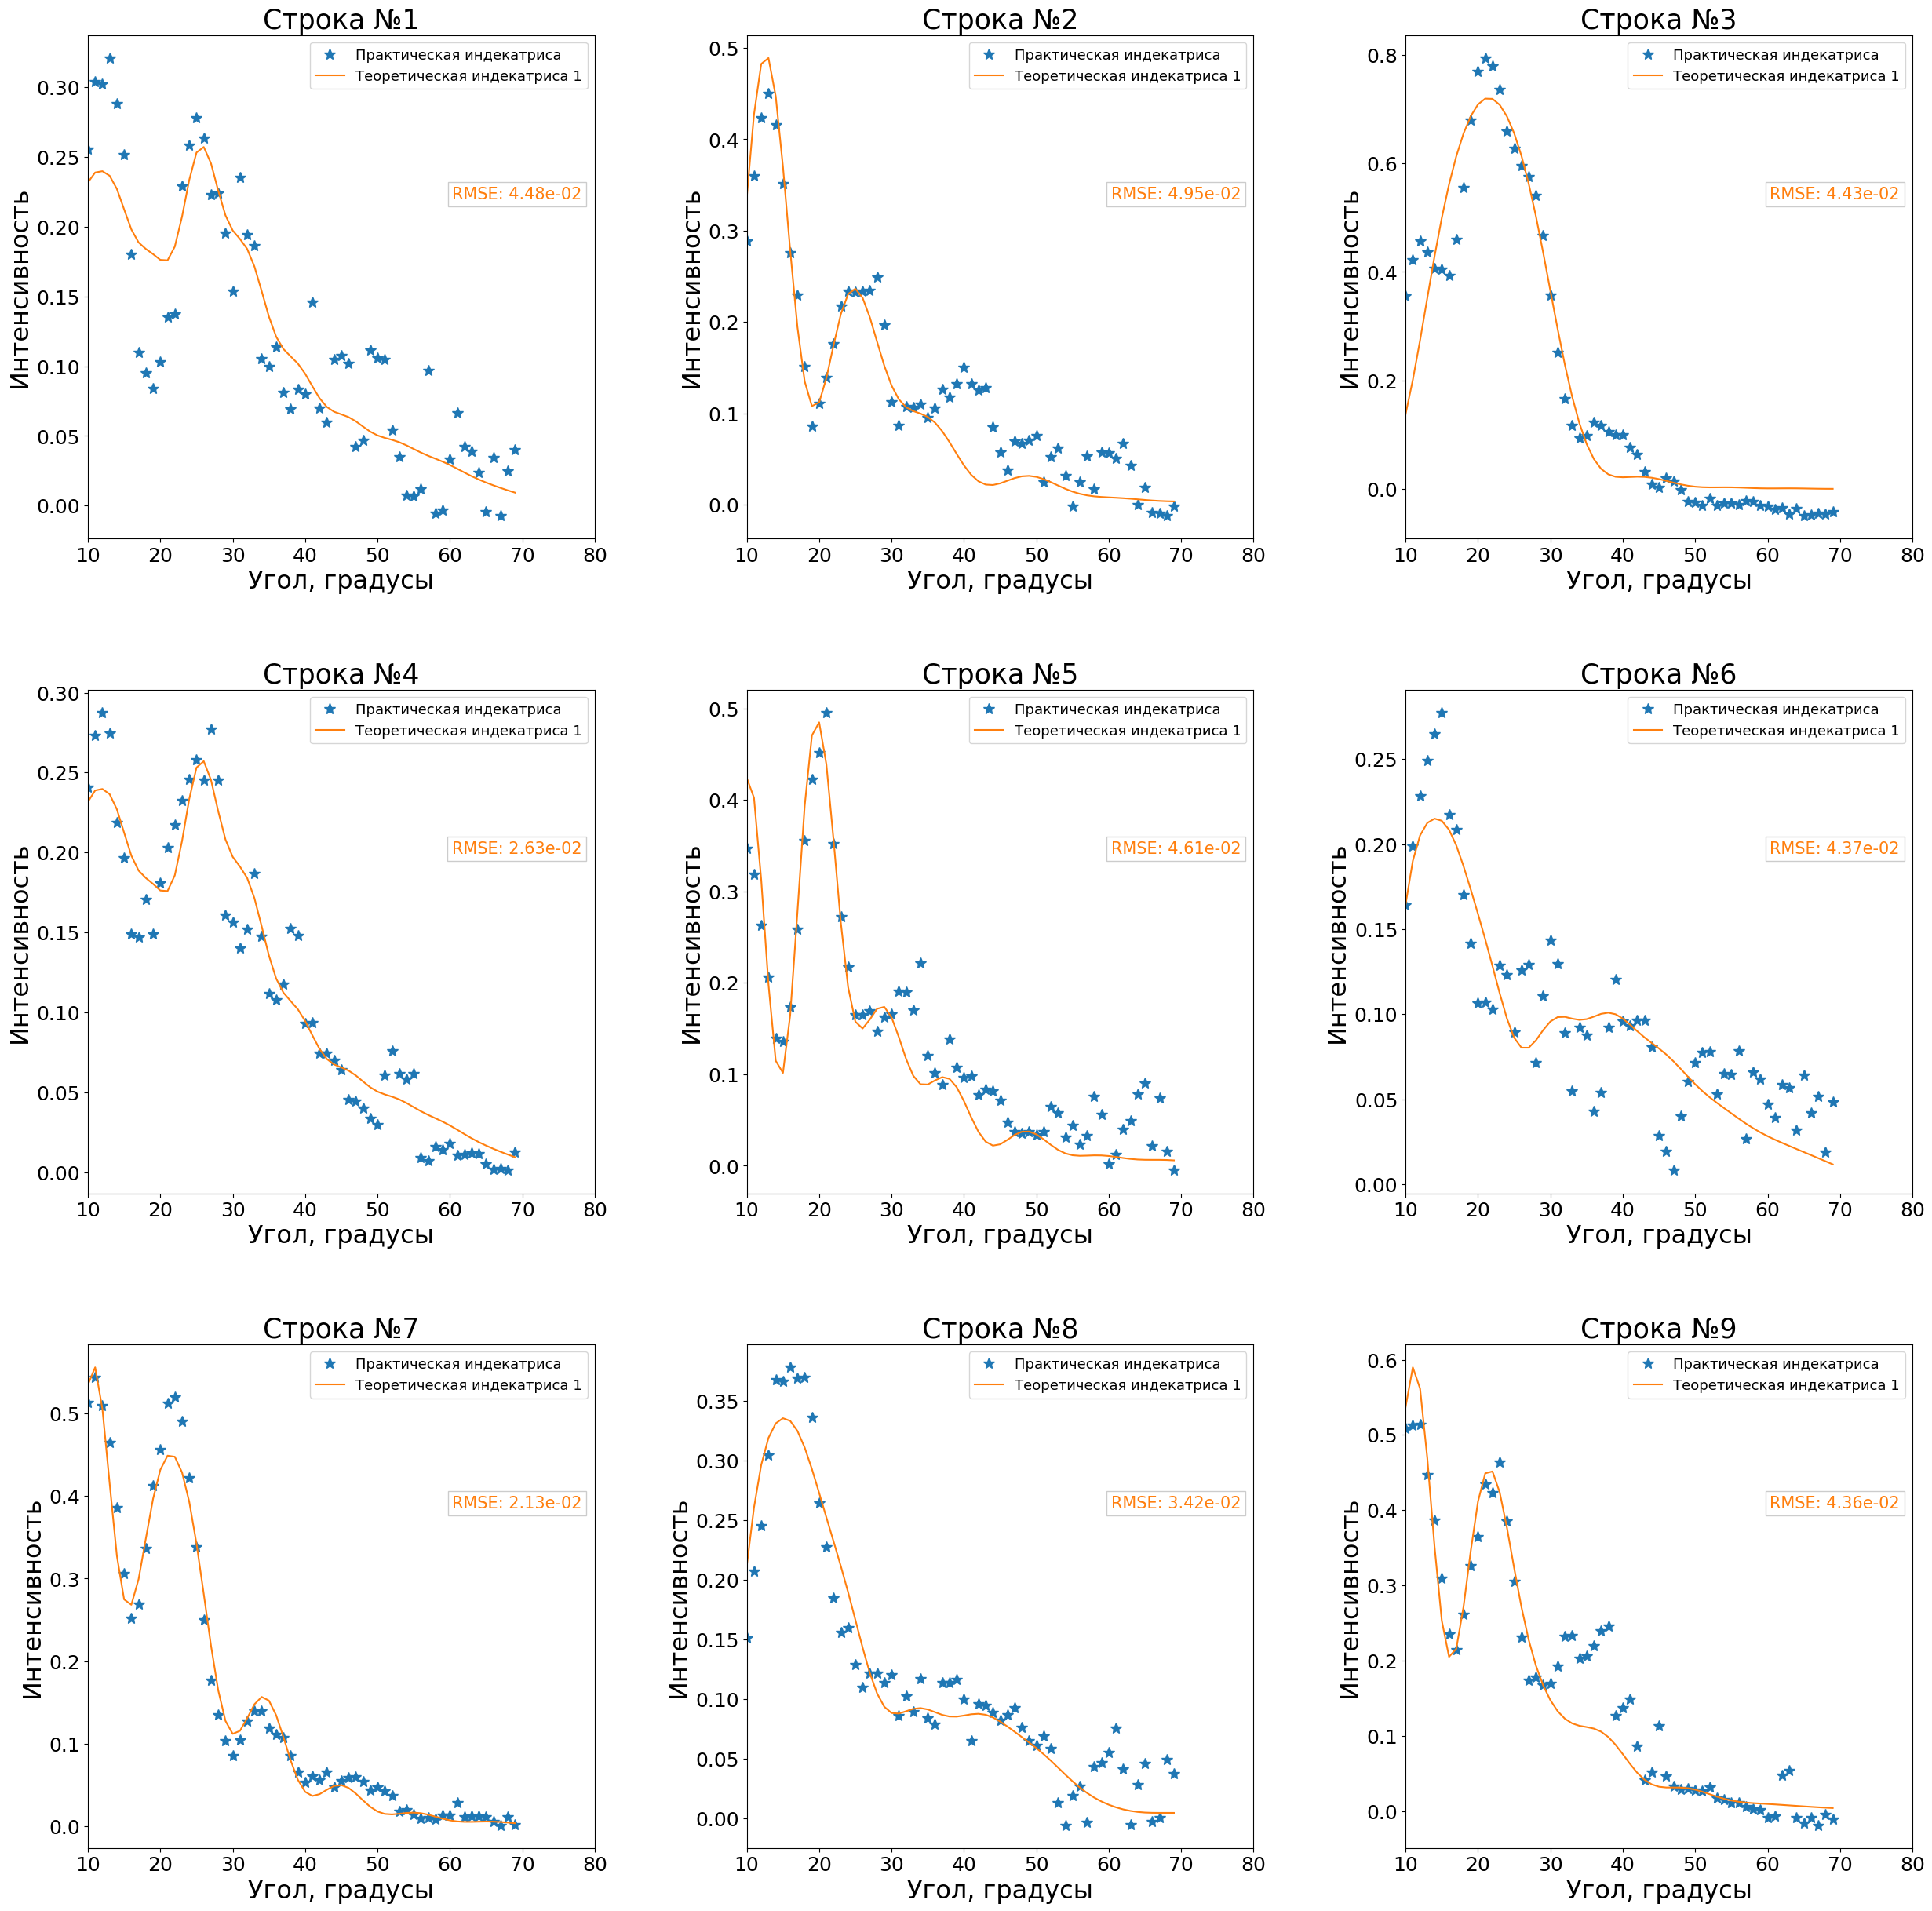

In [40]:
import matplotlib.pyplot as plt

# Общее количество графиков
num_plots = 9  
# Количество строк
rows = 3  
# Количество столбцов
cols = 3  

fig, axes = plt.subplots(rows, cols, figsize=(30, 30))

# Итерация по всем графикам
for i in range(num_plots):

    # Определение текущих строк и столбцов
    row = i // cols
    col = i % cols
    
    # Первые 5 индексов из ind для Train
    row_indices_train = ind[i][:5]  

    # Получение значений интенсивности от угла для выбранных строк
    intensities_test = X_exp_weighted[i]
    intensities_train = X_th_weighted[row_indices_train]

    # Получение углы от 10 до 69 градусов для оси X
    angles = range(10, 70)

    # Список меток для легенды
    labels_train = ['Теоретическая индекатриса {}'.format(i+1) for i in range(len(row_indices_train))]

    # График практической индекатрисы на текущем подграфике
    axes[row, col].plot(angles, intensities_test, label='Практическая индекатриса', marker='*', markersize=10, linestyle='None') 

    # Рассчет mse для лучшего соответствия
    rmse = ((mean_squared_error(X_th_weighted[ind[i][0]], X_exp_weighted[i], multioutput='raw_values')) / ((np.sum(X_th_weighted[ind[i][0]])**2) / len(X_th_weighted[ind[i][0]])))**0.5

    # Отображение MSE на графике
    axes[row, col].text(0.975, 0.7, 'RMSE: {:.2e}'.format(rmse[0]),
                    verticalalignment='top', horizontalalignment='right',
                    transform=axes[row, col].transAxes,
                    color='#ff7f0e', fontsize=15, bbox=dict(facecolor='white', alpha=0.2))


    # Графики теоретических индекатрис на текущем подграфике
    for j, intensities in enumerate(intensities_train):
        axes[row, col].plot(angles, intensities, label=labels_train[j]) 

    # Легенда на текущем подграфике
    axes[row, col].legend(fontsize=13, loc='upper right') 

    # Подписи осей и заголовок на текущем подграфике
    axes[row, col].set_xlabel('Угол, градусы', fontsize=23)  
    axes[row, col].set_ylabel('Интенсивность', fontsize=23) 
    axes[row, col].set_title('Строка №{}'.format(i+1), fontsize=25) 

    # Размер шрифта делений на осях
    axes[row, col].tick_params(axis='both', labelsize=18) 

    axes[row, col].set_xlim(10, 80)

# Увеличение расстояния между графиками
plt.subplots_adjust(hspace=0.3, wspace=0.3)  
plt.show()